# AZT1D Data Analysis

 This section is dedicated to the AZT1D data analysis. It includes basic mean analysis and visualizations, as well as analysis of temporal correlations and patterns between different features.
 The goal is to extract meaningful insights from the data that can inform clinical decisions and improve patient outcomes, as well as to try and experiment with different data processing and analysis techniques, that can be useful for future applications.

### Utilities for loading and preprocessing AZT1D data

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from metrics import *
from data_prep import *

# Filesystem
from pathlib import Path
from typing import List, Dict, Tuple

# Display options (optional but nice)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

save_on_file = False

In [2]:
DATA_ROOT = Path("datasets/AZT1D2025/CGM Records")

SAVE_ROOT = Path("datasets/AZT1D2025/CGM Records/Analysis")

SEP = ","

TARGET_COL = "CGM"

TIME_COL = "EventDateTime"


EXPECTED_COLUMNS = [
    "EventDateTime",
    "DeviceMode",
    "BolusType",
    "Basal",
    "CorrectionDelivered",
    "TotalBolusInsulinDelivered",
    "FoodDelivered",
    "CarbSize",
    "CGM",
]

NUMERIC_COLUMNS = [
    "Basal",
    "CorrectionDelivered",
    "FoodDelivered",
    "TotalBolusInsulinDelivered",
    "CarbSize",
    "CGM"
]

EVENT_COLUMNS = [
    "CorrectionDelivered",
    "FoodDelivered",
    "TotalBolusInsulinDelivered",
    "CarbSize",
]

CATEG_DEFAULTS = {"DeviceMode": "Unknown", "BolusType": "None"}

DEFAULTS = {
    "DeviceMode": "Unknown",
    "BolusType": "None",
    "CorrectionDelivered" : 0.0,
    "FoodDelivered" : 0.0,
    "TotalBolusInsulinDelivered" : 0.0,
    "CarbSize" : 0.0,
}

TARGET_LAGS =(15, 30, 45, 60, 75, 90, 105, 120)



test of data pipeline

In [3]:
data_class = AZT1D2025Dataset(DATA_ROOT, DATA_ROOT / "azt1d2025.yaml", logging_dir=Path("test_log"))

data_class.clean_data()

Found 25 patient CSV files under root (recursive search).
Loaded datasets\AZT1D2025\CGM Records\Subject 01\Subject 1.csv with shape (11042, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 02\Subject 2.csv with shape (11194, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 03\Subject 3.csv with shape (11605, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 04\Subject 4.csv with shape (12822, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 05\Subject 5.csv with shape (13210, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 06\Subject 6.csv with shape (12901, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 07\Subject 7.csv with shape (13392, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 08\Subject 8.csv with shape (8139, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 09\Subject 9.csv with shape (10717, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 10\Subject 10.csv with shape (12183, 9)
Loaded datasets\AZT1D2025\CGM Records\Subject 11\Subject 11.csv with shape (12954, 9)
Loaded

In [14]:
DATA_ROOT = Path("datasets/HUPA-UCM Diabetes Dataset/Preprocessed")

SAVE_ROOT = Path("datasets/AZT1D2025/HUPA-UCM Diabetes Dataset/Analysis")

TARGET_COL = "glucose"
SEP = ";"

TIME_COL = "time"

EXPECTED_COLUMNS = [

]

NUMERIC_COLUMNS = [

]

EVENT_COLUMNS = [

]

CATEG_DEFAULTS = {}

DEFAULTS = {
}



Loading patients data.

In [3]:
all_data = load_dataset(DATA_ROOT, SEP)

Found 25 patient CSV files under root (recursive search).
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0001P.csv with shape (4096, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0002P.csv with shape (3181, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0003P.csv with shape (3770, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0004P.csv with shape (3184, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0005P.csv with shape (3858, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0006P.csv with shape (2290, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0007P.csv with shape (3857, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0009P.csv with shape (3812, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0010P.csv with shape (2976, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\Preprocessed\HUPA0011P.csv with shape (3839, 8)
Loaded datasets\HUPA-UCM Diabetes Dataset\

Reading and cleaning data for all patients.

Null values are handled as follows:
- Numeric columns are coerced to float, with non-numeric entries converted to NaN and null values filled with 0.0 except for CGM.
- Categorical columns are converted to 'category' dtype; missing values are filled with "Unknown" or "None".

In [3]:
for i in range(len(all_data)):
    df = all_data[i]
    
    df = df.rename(columns=lambda c: c.strip())  # pulisce spazi


    # Ensure all expected columns exist; if missing, create as NaN
    for col in EXPECTED_COLUMNS:
        if col not in df.columns:

            df[col] = np.nan

    # Keep only expected columns (and in the expected order)
    df = df[EXPECTED_COLUMNS]

    # Parse datetime
    df["EventDateTime"] = pd.to_datetime(df["EventDateTime"], errors="coerce", utc=True)

    # Set index and sort
    df = df.set_index("EventDateTime").sort_index()

    # Coerce numeric columns
    for c in NUMERIC_COLUMNS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    #
    df["Basal"] = df["Basal"].astype(float).clip(lower=0.0, upper=7.0).ffill()

    # Fill NaN values with last non-NaN value
    df["Basal"] = df["Basal"].ffill()

    df[EVENT_COLUMNS] = df[EVENT_COLUMNS].fillna(0.0)

    df[EVENT_COLUMNS] = df[EVENT_COLUMNS].clip(lower=0.0)

    # DeviceMode and BolusType are categorical
    if "DeviceMode" in df:
        df["DeviceMode"] = df["DeviceMode"].replace({"0": "Unknown", 0: "Unknown"}).fillna("Unknown").astype(
            "category")

    if "BolusType" in df:
        df["BolusType"] = df["BolusType"].replace({"0": "None", 0: "None"}).fillna("None").astype("category")

    all_data[i] = df

In [8]:
for i in range(len(all_data)):
    df = all_data[i]
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=True)
    df = df.set_index(TIME_COL).sort_index()
    all_data[i] = df


In [9]:
print_df_summary(all_data)


📊 DataFrame summary Subject 1: (4,096 rows, 7 columns)

🔹 glucose  [float64]
   • unique values: 577
   • missing values: 0.0%
   • min=40.00, median=165.67, max=444.00
   • most frequent values:
       136.00 → 37
       126.00 → 36
       158.00 → 34
       132.00 → 34
       145.00 → 33
----------------------------------------------------------------------------------------------------

🔹 calories  [float64]
   • unique values: 654
   • missing values: 0.0%
   • min=4.03, median=4.19, max=37.51
   • most frequent values:
       4.03 → 1669
       4.11 → 327
       4.19 → 178
       4.35 → 62
       4.27 → 49
----------------------------------------------------------------------------------------------------

🔹 heart_rate  [float64]
   • unique values: 4015
   • missing values: 0.0%
   • min=53.46, median=81.01, max=167.32
   • most frequent values:
       82.35 → 3
       79.00 → 3
       89.00 → 3
       89.47 → 2
       66.00 → 2
--------------------------------------------------

### Duplicate timestamp cleaning

In this section, we check for and handle duplicate timestamps in the CGM data for each patient. Duplicate timestamps can arise from device errors or data entry issues and need to be addressed to ensure accurate time series analysis.

In [10]:
for i, df in enumerate(all_data, start=1):
    subject = f"Subject {i:02d}"

    if df is None or df.empty:
        print(f"[{subject}] empty DataFrame")
        continue
    if not isinstance(df.index, pd.DatetimeIndex):
        print(f"[{subject}] index is not a DatetimeIndex")
        continue

    # Find duplicated rows by timestamp (in the index)
    dup_mask = df.index.duplicated(keep=False)
    n_dup_rows = int(dup_mask.sum())
    if n_dup_rows == 0:
        print(f"[{subject}] no duplicate timestamps")
        continue

    # How many distinct duplicated timestamps?
    n_dup_timestamps = df.index[dup_mask].nunique()

    print(f"[{subject}] {n_dup_rows} duplicate rows across "
          f"{n_dup_timestamps} duplicated timestamps")

    # Show first 3 duplicated timestamps with their counts
    vc = df.index.value_counts().sort_index()
    dups = vc[vc > 1].head(3)
    for ts, cnt in dups.items():
        print(f"   - {ts}  (count = {cnt})")

[Subject 01] no duplicate timestamps
[Subject 02] no duplicate timestamps
[Subject 03] no duplicate timestamps
[Subject 04] no duplicate timestamps
[Subject 05] no duplicate timestamps
[Subject 06] no duplicate timestamps
[Subject 07] no duplicate timestamps
[Subject 08] no duplicate timestamps
[Subject 09] no duplicate timestamps
[Subject 10] no duplicate timestamps
[Subject 11] no duplicate timestamps
[Subject 12] no duplicate timestamps
[Subject 13] no duplicate timestamps
[Subject 14] no duplicate timestamps
[Subject 15] no duplicate timestamps
[Subject 16] no duplicate timestamps
[Subject 17] no duplicate timestamps
[Subject 18] no duplicate timestamps
[Subject 19] no duplicate timestamps
[Subject 20] no duplicate timestamps
[Subject 21] no duplicate timestamps
[Subject 22] no duplicate timestamps
[Subject 23] no duplicate timestamps
[Subject 24] no duplicate timestamps
[Subject 25] no duplicate timestamps


We decide to keep the first occurrence of each duplicated timestamp and drop the rest. This approach is simple and effective for our analysis, as it preserves the initial reading while removing redundant entries.

In [11]:
all_data_nodup = clean_duplicates(all_data)

[Subject 1] no duplicates removed
[Subject 2] no duplicates removed
[Subject 3] no duplicates removed
[Subject 4] no duplicates removed
[Subject 5] no duplicates removed
[Subject 6] no duplicates removed
[Subject 7] no duplicates removed
[Subject 8] no duplicates removed
[Subject 9] no duplicates removed
[Subject 10] no duplicates removed
[Subject 11] no duplicates removed
[Subject 12] no duplicates removed
[Subject 13] no duplicates removed
[Subject 14] no duplicates removed
[Subject 15] no duplicates removed
[Subject 16] no duplicates removed
[Subject 17] no duplicates removed
[Subject 18] no duplicates removed
[Subject 19] no duplicates removed
[Subject 20] no duplicates removed
[Subject 21] no duplicates removed
[Subject 22] no duplicates removed
[Subject 23] no duplicates removed
[Subject 24] no duplicates removed
[Subject 25] no duplicates removed


### Gap analysis

In this section, we analyze the gaps in CGM data for each patient. We compute the total duration of gaps, the number of gaps, and the average gap length. The gaps will be plotted for visual inspection. Moreover, we will explore techniques to fill/handle gaps of various lengths.

In [12]:
expected_td = pd.Timedelta("5min")
tol_td = pd.Timedelta("5s")
threshold = expected_td + tol_td

for i in range(0, all_data_nodup.__len__()):
    p_df = all_data_nodup[i]
    idx = p_df.index.sort_values()
    diffs = idx.to_series().diff().dropna()
    gaps = diffs[diffs > threshold]

    if gaps.empty:
        print(f"[{i+1}]  ✅ no gaps > 5min (+5s)")
    else:
        total_gap = gaps.sum()
        mean_gap = gaps.mean()
        print(f"[{i+1}]  {len(gaps)} gaps > 5min (+5s) | "
              f"largest: {gaps.max()} | "
              f"total: {total_gap} | "
              f"mean: {mean_gap}")
        # print first 2 examples
        for ts, delta in gaps.head(2).items():
            print(f"   gap before {ts} = {delta}")

[1]  ✅ no gaps > 5min (+5s)
[2]  ✅ no gaps > 5min (+5s)
[3]  ✅ no gaps > 5min (+5s)
[4]  ✅ no gaps > 5min (+5s)
[5]  ✅ no gaps > 5min (+5s)
[6]  ✅ no gaps > 5min (+5s)
[7]  ✅ no gaps > 5min (+5s)
[8]  ✅ no gaps > 5min (+5s)
[9]  ✅ no gaps > 5min (+5s)
[10]  ✅ no gaps > 5min (+5s)
[11]  ✅ no gaps > 5min (+5s)
[12]  ✅ no gaps > 5min (+5s)
[13]  ✅ no gaps > 5min (+5s)
[14]  ✅ no gaps > 5min (+5s)
[15]  ✅ no gaps > 5min (+5s)
[16]  ✅ no gaps > 5min (+5s)
[17]  ✅ no gaps > 5min (+5s)
[18]  ✅ no gaps > 5min (+5s)
[19]  ✅ no gaps > 5min (+5s)
[20]  ✅ no gaps > 5min (+5s)
[21]  ✅ no gaps > 5min (+5s)
[22]  ✅ no gaps > 5min (+5s)
[23]  ✅ no gaps > 5min (+5s)
[24]  ✅ no gaps > 5min (+5s)
[25]  ✅ no gaps > 5min (+5s)


Gap plotting functions on timeline.

In [42]:
if not save_on_file:
    for i in range(0, all_data_nodup.__len__()):

        p_df = all_data_nodup[i]
        idx = p_df.index.sort_values()
        diffs = idx.to_series().diff().dropna()
        gaps = diffs[diffs > threshold]


        fig, ax = plt.subplots(figsize=(12, 2.2))
        # Whole monitoring span
        ax.hlines(y=0, xmin=idx.min(), xmax=idx.max(), color="black", linewidth=5, alpha=0.35)
        # Gap segments
        for ts, delta in gaps.items():
            ax.hlines(y=0, xmin=ts - delta, xmax=ts, color="red", linewidth=10)
        ax.set_yticks([])
        ax.set_title(f"{i+1} — gaps > 5min (+5s) (n={len(gaps)})")
        ax.set_xlabel("Time")
        plt.tight_layout()

        plt.show()
else:
    print("Plotting skipped")



Plotting skipped


We decide to handle timestamp uniformization and gap filling as follows:
- Round timestamps to the nearest 5-minute mark to create a uniform time grid.
- Interpolate CGM values for gaps up to 20 minutes (4 consecutive missing readings).

In [15]:
EXPECTED       = pd.Timedelta("5min")
MAX_SMALL_GAP  = pd.Timedelta("20min")   # interpolate up to 20 min

all_data_filled = fill_data(
    all_data_nodup,
    EXPECTED,
    MAX_SMALL_GAP,
    TARGET_COL,
    DEFAULTS
)

all_data_filled[0].head(20)

[Subject 1] filled 4096 rows
[Subject 2] filled 3181 rows
[Subject 3] filled 3770 rows
[Subject 4] filled 3184 rows
[Subject 5] filled 3858 rows
[Subject 6] filled 2290 rows
[Subject 7] filled 3857 rows
[Subject 8] filled 3812 rows
[Subject 9] filled 2976 rows
[Subject 10] filled 3839 rows
[Subject 11] filled 3829 rows
[Subject 12] filled 3792 rows
[Subject 13] filled 3835 rows
[Subject 14] filled 3599 rows
[Subject 15] filled 3895 rows
[Subject 16] filled 3711 rows
[Subject 17] filled 2862 rows
[Subject 18] filled 2343 rows
[Subject 19] filled 4023 rows
[Subject 20] filled 3919 rows
[Subject 21] filled 2902 rows
[Subject 22] filled 4006 rows
[Subject 23] filled 40605 rows
[Subject 24] filled 165306 rows
[Subject 25] filled 25902 rows


,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
time,,,,,,,
2018-06-13 18:40:00+00:00,332.0,6.3595,82.322835,34.0,0.091667,0.0,0.0
2018-06-13 18:45:00+00:00,326.0,7.7280,83.740157,0.0,0.091667,0.0,0.0
2018-06-13 18:50:00+00:00,330.0,4.7495,80.525180,0.0,0.091667,0.0,0.0
2018-06-13 18:55:00+00:00,324.0,6.3595,89.129032,20.0,0.091667,0.0,0.0
2018-06-13 19:00:00+00:00,306.0,5.1520,92.495652,0.0,0.075000,0.0,0.0
2018-06-13 19:05:00+00:00,313.0,6.6010,92.000000,6.0,0.075000,0.0,0.0
2018-06-13 19:10:00+00:00,312.0,10.1430,91.339623,48.0,0.075000,0.0,0.0
2018-06-13 19:15:00+00:00,293.0,6.8425,89.893443,0.0,0.075000,0.0,0.0
2018-06-13 19:20:00+00:00,303.0,5.2325,89.352941,0.0,0.075000,0.0,0.0


We visualize the segments where CGM values were inferred (interpolated) and where they remain NaN even after interpolation. Inferred segments (up to 20 minutes) are shown in blue, while persistent NaN segments (longer than 20 minutes) are shown in red.

It is shown that with a regular grid we may have introduced some deviation from the original timestamps (+-2.5 min), but this is acceptable for our analysis.

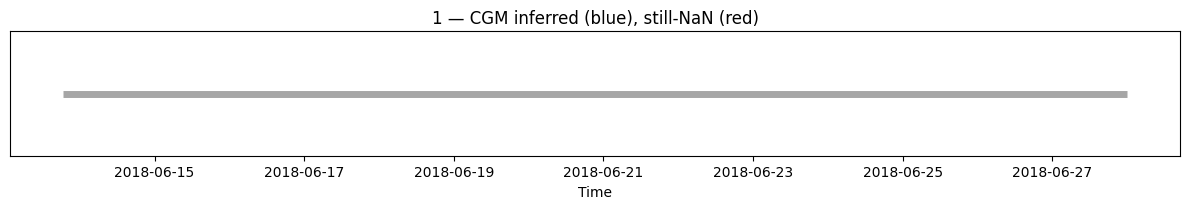

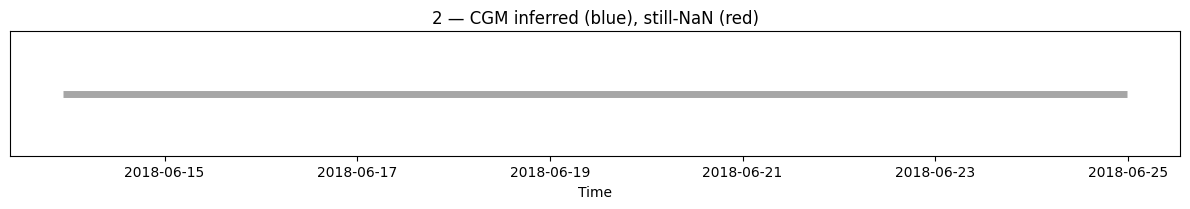

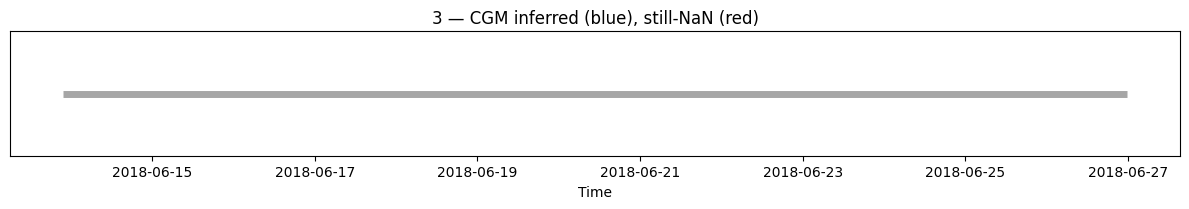

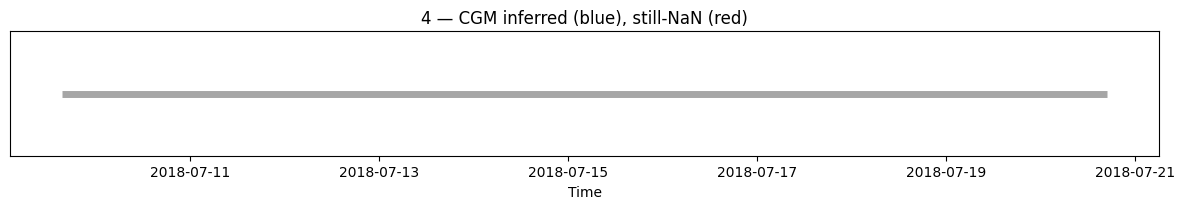

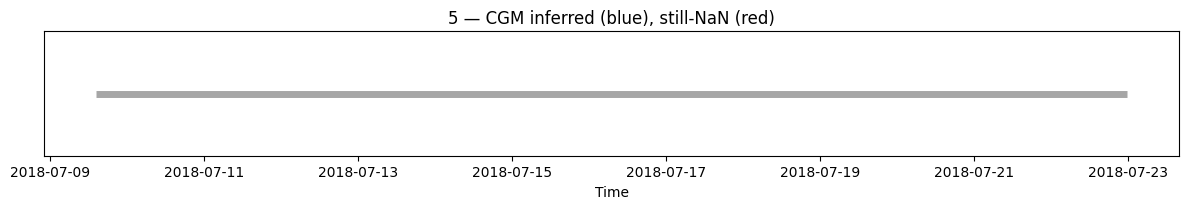

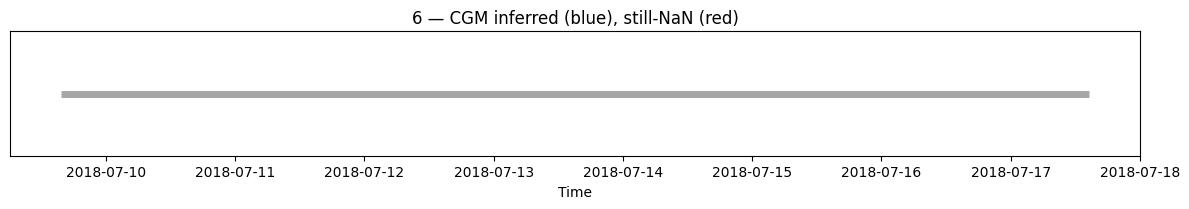

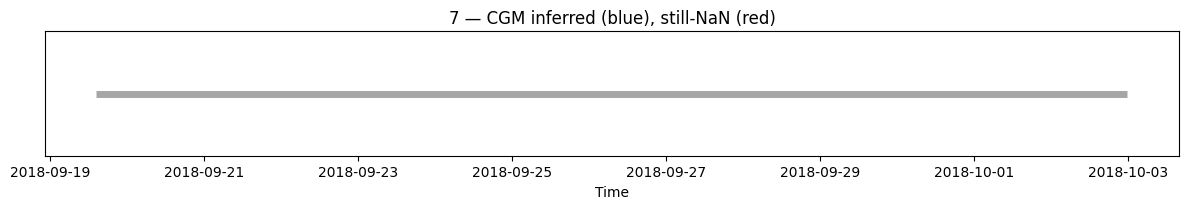

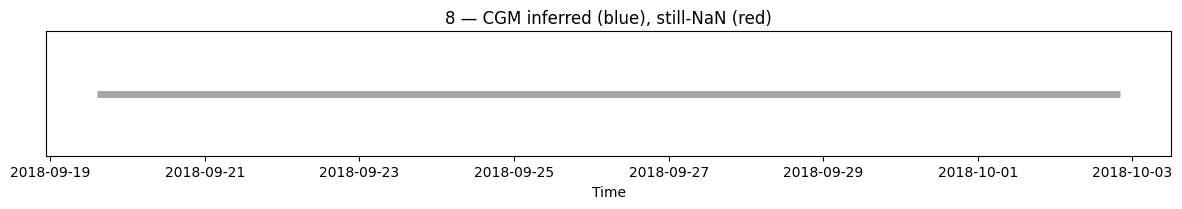

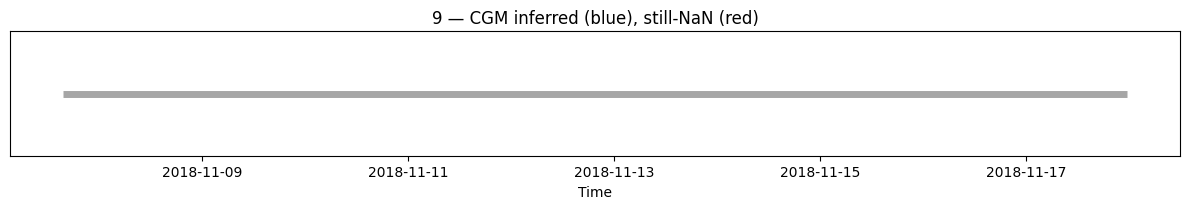

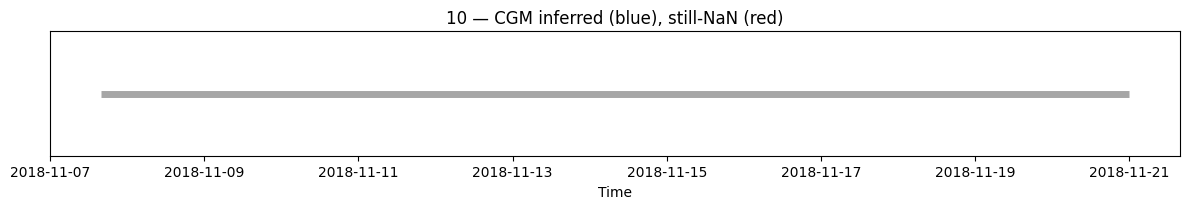

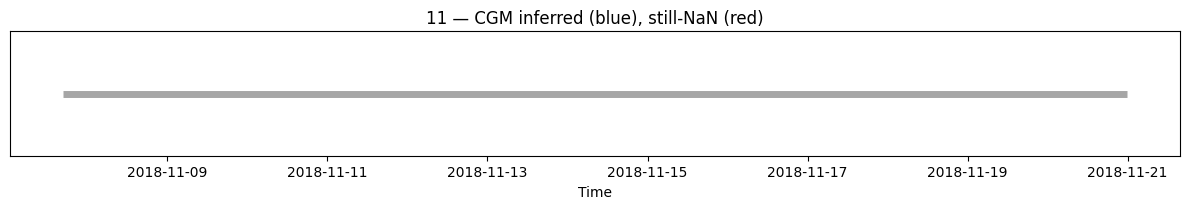

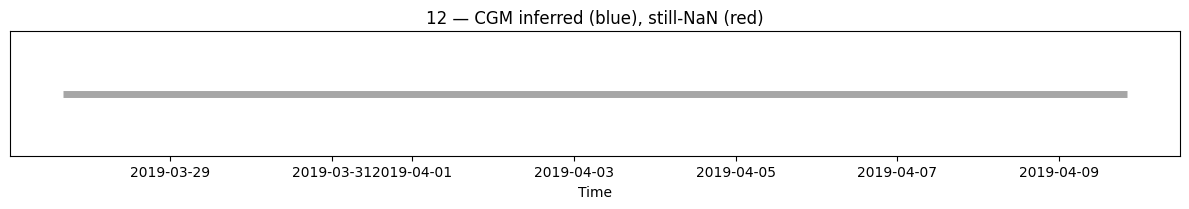

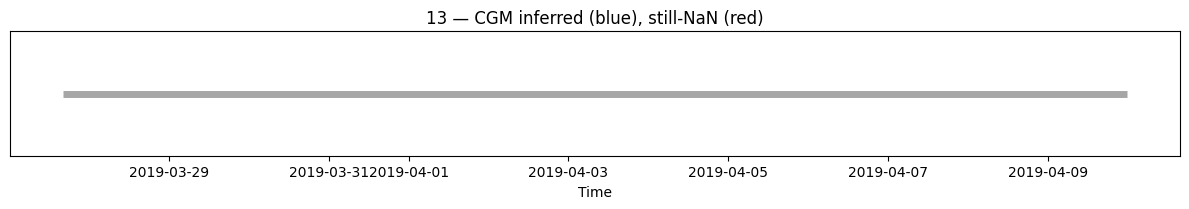

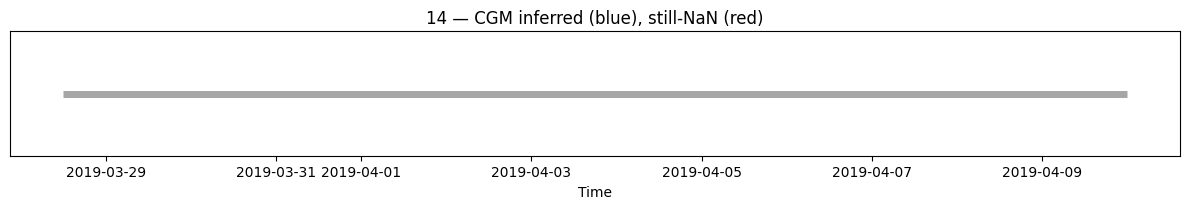

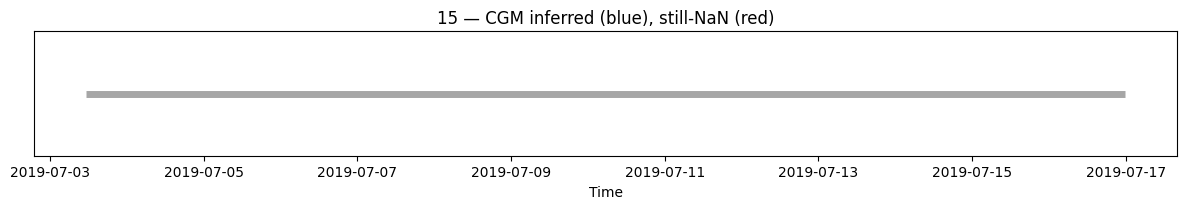

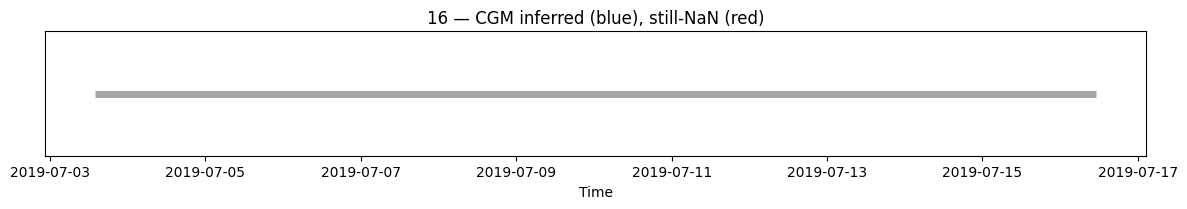

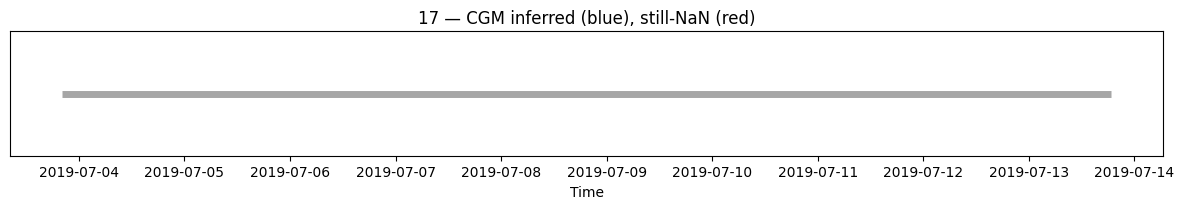

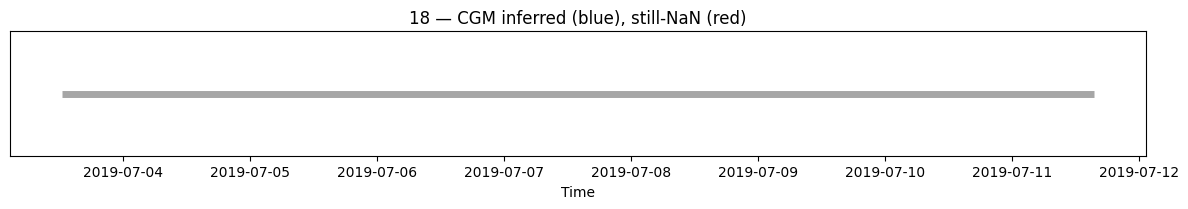

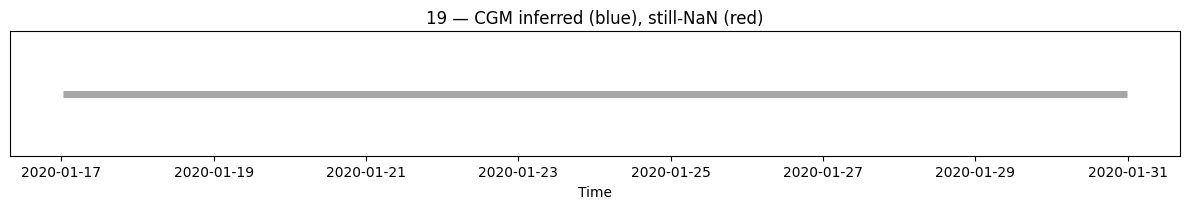

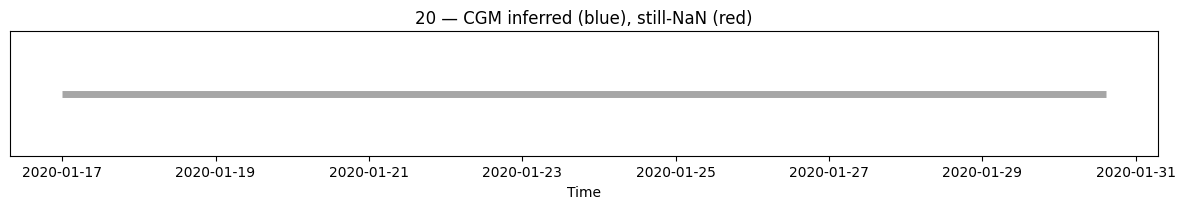

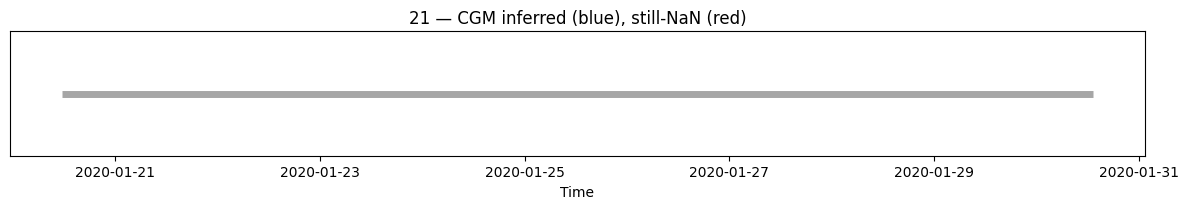

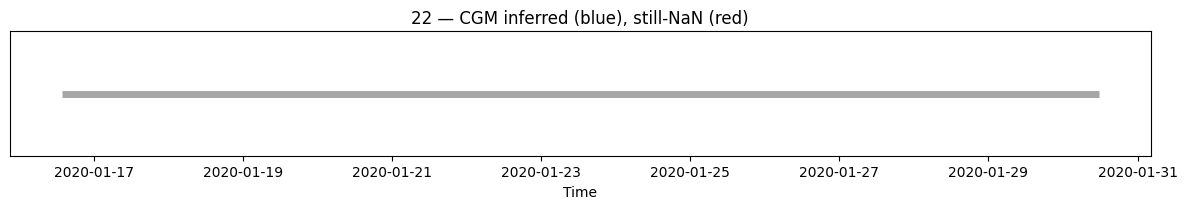

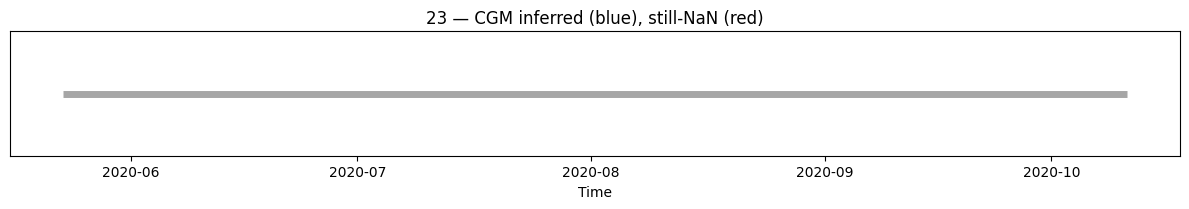

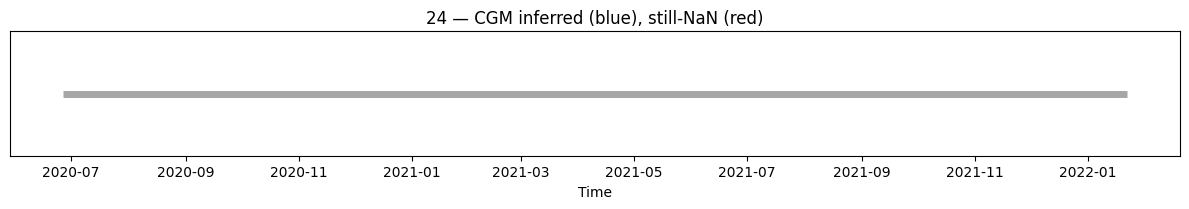

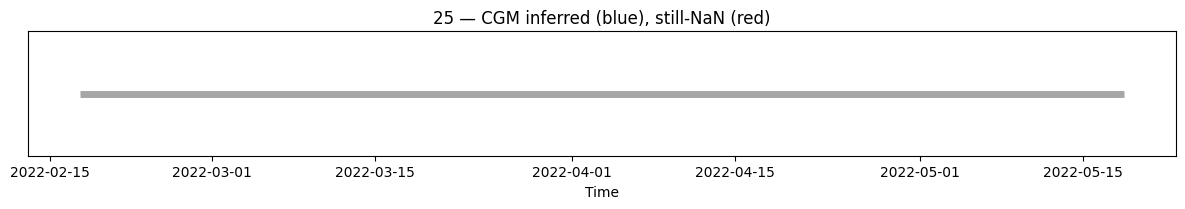

In [20]:
save_path = SAVE_ROOT / "gaps"
save_path.mkdir(parents=True, exist_ok=True)


for i in range(len(all_data_nodup)):
    p_df_after  = all_data_filled[i]                     # AFTER interpolation (on exact grid)
    p_df_before = all_data_nodup[i].sort_index().copy()  # BEFORE (raw)

    # Snap raw to 5-min bins and deduplicate, then align exactly to AFTER index
    # 1. Trova l'origine esatta usata nel riempimento
    # (Non è necessario ricalcolarla, è già nel DataFrame finale se lo ricrei)
    origin_time = p_df_before.index.min()

    # 2. Allinea il DataFrame RAW (originale) alla griglia OFFSET PERFETTA
    #    usando la stessa logica di fill_data (resample.last).
    p_df_before_on_grid = p_df_before.resample(EXPECTED, origin=origin_time).last()

    # 3. Riallinea l'indice: Se p_df_before_on_grid avesse una lunghezza diversa,
    #    la forziamo ad allinearsi all'indice perfetto di p_df_after (che è il riferimento)
    p_df_before_on_grid = p_df_before_on_grid.reindex(p_df_after.index)

    # Masks on the same grid
    mask_inferred = p_df_before_on_grid[TARGET_COL].isna() & p_df_after[TARGET_COL].notna()
    mask_still_na = p_df_before_on_grid[TARGET_COL].isna() & p_df_after[TARGET_COL].isna()

    # Helper to group contiguous timestamps into segments
    def to_segments(ts_index, base_idx):
        if len(ts_index) == 0:
            return []
        sampling = base_idx.to_series().diff().median()
        brk = ts_index.to_series().diff() > sampling * 1.1
        grp = brk.cumsum()
        grouped = ts_index.to_series().groupby(grp)
        return [(g.min(), g.max()) for _, g in grouped]

    # Use the AFTER index as base (regular grid)
    idx = p_df_after.index

    inferred_times = idx[mask_inferred]
    persist_times  = idx[mask_still_na]       # <-- fixed name

    segments_inferred = to_segments(inferred_times, idx)
    segments_persist  = to_segments(persist_times,  idx)

    # (Optional) structural gaps: with a regular grid they are empty;
    # if you still want orange bars, compute gaps from the ORIGINAL raw index BEFORE rounding.
    gaps = []  # leave empty to avoid confusion on the regular grid

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 2.2))
    ax.hlines(y=0, xmin=idx.min(), xmax=idx.max(), color="black", linewidth=5, alpha=0.35)

    # Structural gaps (orange) - only if you computed them above
    for ts, delta in gaps:
        ax.hlines(y=0, xmin=ts - delta, xmax=ts, color="orange", linewidth=10, label="Index gaps > threshold")
        break  # ensures single legend entry

    # Still NaN (red)
    first = True
    for start, end in segments_persist:
        ax.hlines(y=0, xmin=start, xmax=end, color="red", linewidth=10,
                  label="Still NaN (before & after)" if first else "")
        first = False

    # Inferred (blue)
    first = True
    for start, end in segments_inferred:
        ax.hlines(y=0, xmin=start, xmax=end, color="blue", linewidth=10,
                  label="Inferred (≤20 min)" if first else "")
        first = False

    ax.set_yticks([])
    ax.set_title(f"{i+1} — CGM inferred (blue), still-NaN (red)")
    ax.set_xlabel("Time")
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper right")
    plt.tight_layout()

    if not save_on_file:
        plt.show()
    else:
        plt.savefig(save_path / f"subject_{i+1}.png")
        print(f"Saved plot in {save_path / f"subject_{i+1}.png"}")

    plt.close(fig)


Other gap handling strategies could include forward/backward filling or more sophisticated imputation methods, depending on the analysis needs. For the sake of this notebook, which focuses on analysis rather than prediction, we will primarily use linear interpolation for small gaps and leave larger gaps as NaN. The handling for larger gaps will be based on segmentation and will be metric-specific.

In [6]:
print_df_summary(all_data_filled)


📊 DataFrame summary Subject 1: (11,231 rows, 8 columns)

🔹 DeviceMode  [category]
   • unique values: 1
   • missing values: 2.2%
   • most frequent values:
       Unknown → 10989
----------------------------------------------------------------------------------------------------

🔹 BolusType  [category]
   • unique values: 6
   • missing values: 2.2%
   • most frequent values:
       None → 10455
       Standard/Correction → 284
       Standard → 151
       Automatic Bolus/Correction → 96
       BLE Standard Bolus/Correction → 2
----------------------------------------------------------------------------------------------------

🔹 Basal  [float64]
   • unique values: 407
   • missing values: 34.8%
   • min=0.00, median=2.10, max=5.67
   • most frequent values:
       3.00 → 550
       2.20 → 431
       2.10 → 384
       2.90 → 246
       1.93 → 156
----------------------------------------------------------------------------------------------------

🔹 CorrectionDelivered  [float64]
  

### Feature extraction
In this section, we define new columns in the dataset which will be needed for more complex metrics

In [6]:
all_data_complete = []

for i, df in enumerate(all_data_filled):
    df = add_target_lags(
        df,
        TARGET_COL,
        TARGET_LAGS
    )

    df = add_time_of_day_features(df)

    df = add_event_present_indicator(df, "Basal")
    for col in EVENT_COLUMNS:
        df = add_event_present_indicator(df, col)
        df = add_exponential_decay_feature(df, col, halflife_min = 120)

    df = encode_bolus_type_semantic(df, "BolusType")

    all_data_complete.append(df)
    print(f"[Subject {i+1}] Added features.")


[Subject 1] Added features.
[Subject 2] Added features.
[Subject 3] Added features.
[Subject 4] Added features.
[Subject 5] Added features.
[Subject 6] Added features.
[Subject 7] Added features.
[Subject 8] Added features.
[Subject 9] Added features.
[Subject 10] Added features.
[Subject 11] Added features.
[Subject 12] Added features.
[Subject 13] Added features.
[Subject 14] Added features.
[Subject 15] Added features.
[Subject 16] Added features.
[Subject 17] Added features.
[Subject 18] Added features.
[Subject 19] Added features.
[Subject 20] Added features.
[Subject 21] Added features.
[Subject 22] Added features.
[Subject 23] Added features.
[Subject 24] Added features.
[Subject 25] Added features.


In [14]:
print_df_summary(all_data_complete)


📊 DataFrame summary Subject 1: (11,231 rows, 36 columns)

🔹 DeviceMode  [category]
   • unique values: 1
   • missing values: 2.2%
   • most frequent values:
       Unknown → 10989
----------------------------------------------------------------------------------------------------

🔹 BolusType  [category]
   • unique values: 6
   • missing values: 2.2%
   • most frequent values:
       None → 10455
       Standard/Correction → 284
       Standard → 151
       Automatic Bolus/Correction → 96
       BLE Standard Bolus/Correction → 2
----------------------------------------------------------------------------------------------------

🔹 Basal  [float64]
   • unique values: 407
   • missing values: 34.8%
   • min=0.00, median=2.10, max=5.67
   • most frequent values:
       3.00 → 550
       2.20 → 431
       2.10 → 384
       2.90 → 246
       1.93 → 156
----------------------------------------------------------------------------------------------------

🔹 CorrectionDelivered  [float64]
 

In [7]:
extras = {
    "none": [],
    "with_Basal_present": ["Basal_present"],
    "with_Basal": ["Basal"],  # meglio: ["Basal_filled"]
}

# 1) Build one common mask that covers ALL columns possibly used
base_cols = [f"CGM_lag_{m}m" for m in TARGET_LAGS] + ["tod_sin_24h","tod_cos_24h"]
cand_base = [
    "FoodDelivered_expdecay_120m",
    "CarbSize_expdecay_120m",
    "TotalBolusInsulinDelivered_expdecay_120m",
    "bt_is_extended","bt_is_auto","bt_is_quick","bt_is_correction",
]
for i, df in enumerate(all_data_complete):
    # --- choose your extras ---

    all_needed = set(base_cols + cand_base + sum(extras.values(), []))

    # future target mask
    dt_min = df.index.to_series().diff().dt.total_seconds().div(60.0).bfill().median()
    h = max(1, round(60 / dt_min))
    y_ok = df["CGM"].shift(-h).notna()

    mask = y_ok.copy()
    for c in all_needed:
        if c in df.columns:
            mask &= df[c].notna()

    df_same = df.loc[mask]

    # 2) Run the three variants on the EXACT same rows
    out = {}
    for name, ex in extras.items():
        res = compute_arx_delta_r2(
            df_same, target_col="CGM",
            candidate_cols=cand_base + ex,
            lag_minutes=list(TARGET_LAGS),
            horizon_min=60,
            add_time_of_day=True,
            n_splits=5,
            alpha=1.0,
        )
        out[name] = res["delta_r2_mean"]
    print(f"Subject {i+1}:")
    print("ΔR² (same sample):", out)
    print("n_rows:", len(df_same))


Subject 1:
ΔR² (same sample): {'none': 7.516788194894541e-05, 'with_Basal_present': 0.0005450121454559032, 'with_Basal': 0.02723537723824576}
n_rows: 7127
Subject 2:
ΔR² (same sample): {'none': 0.0010032766791879145, 'with_Basal_present': -0.007085230711887647, 'with_Basal': 0.10071162486884884}
n_rows: 7871
Subject 3:
ΔR² (same sample): {'none': 0.014911623281418374, 'with_Basal_present': 0.007656106830587728, 'with_Basal': 0.02109594910098269}
n_rows: 7000
Subject 4:
ΔR² (same sample): {'none': 0.013962677902651977, 'with_Basal_present': 0.01377914065288528, 'with_Basal': 0.07225865488790797}
n_rows: 7560
Subject 5:
ΔR² (same sample): {'none': 0.004742130258733712, 'with_Basal_present': 0.013083449779908852, 'with_Basal': 0.0411474115746707}
n_rows: 7651
Subject 6:
ΔR² (same sample): {'none': 0.019319497370872084, 'with_Basal_present': 0.024353501232962694, 'with_Basal': 0.08702061628854016}
n_rows: 7462
Subject 7:
ΔR² (same sample): {'none': 0.03080282737244664, 'with_Basal_present'

### Metrics
In this section, we define functions to compute various metrics from the CGM time series data.

In [8]:
report = []
for i in range(len(all_data_filled)):
    report.append({})

In [9]:
print(report)

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]


#### Basic statistics

Mean glucose value is a basic but important statistic for understanding a patient's glucose levels over time.

In [47]:
for i in range(len(all_data_filled)):

    cgm = all_data_filled[i]["CGM"]

    s = cgm.dropna()
    mean_glucose = s.mean() if len(s) > 0 else np.nan

    print("Subject ", i+1, "mean glucose:", mean_glucose)

    report[i]["mean_glucose"] = float(mean_glucose)


Subject  1 mean glucose: 141.73079706413037
Subject  2 mean glucose: 155.8842820643721
Subject  3 mean glucose: 140.14749107244037
Subject  4 mean glucose: 170.85797976372896
Subject  5 mean glucose: 134.51745975887016
Subject  6 mean glucose: 143.32176911434604
Subject  7 mean glucose: 142.481779526812
Subject  8 mean glucose: 160.14769259396684
Subject  9 mean glucose: 191.03344121645523
Subject  10 mean glucose: 155.29870988824305
Subject  11 mean glucose: 166.10085230593444
Subject  12 mean glucose: 135.44868170843532
Subject  13 mean glucose: 134.59002447636186
Subject  14 mean glucose: 107.34999542430106
Subject  15 mean glucose: 137.03547645492193
Subject  16 mean glucose: 148.77441915277439
Subject  17 mean glucose: 154.1762986669987
Subject  18 mean glucose: 152.13148961564255
Subject  19 mean glucose: 132.32951750206118
Subject  20 mean glucose: 133.31160690438034
Subject  21 mean glucose: 158.46750274135277
Subject  22 mean glucose: 141.6264012336909
Subject  23 mean glucose

Standard deviation (SD) of glucose values, which provides insight into the variability of glucose levels.

In [48]:
for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]

    s = cgm.dropna()
    sd_glucose = s.std(ddof=1) if len(s) > 0 else np.nan

    report[i]["sd_glucose"] = float(sd_glucose)

    print("Subject ", i+1, " sd_glucose:", sd_glucose)

Subject  1  sd_glucose: 36.51615205037035
Subject  2  sd_glucose: 44.092720966918776
Subject  3  sd_glucose: 41.04574241944228
Subject  4  sd_glucose: 53.13874282642788
Subject  5  sd_glucose: 43.70199527873568
Subject  6  sd_glucose: 32.69263577585195
Subject  7  sd_glucose: 36.52974104323808
Subject  8  sd_glucose: 50.21871250087837
Subject  9  sd_glucose: 67.3568404491339
Subject  10  sd_glucose: 52.93730586548436
Subject  11  sd_glucose: 51.56764949861843
Subject  12  sd_glucose: 42.281723476437
Subject  13  sd_glucose: 28.70934991383419
Subject  14  sd_glucose: 27.23316531868929
Subject  15  sd_glucose: 53.1179756643687
Subject  16  sd_glucose: 46.17763766682194
Subject  17  sd_glucose: 52.37518668120098
Subject  18  sd_glucose: 49.11137904123967
Subject  19  sd_glucose: 34.46220146985152
Subject  20  sd_glucose: 33.89375703056872
Subject  21  sd_glucose: 55.6014729948343
Subject  22  sd_glucose: 40.41346166766867
Subject  23  sd_glucose: 39.58441307741484
Subject  24  sd_glucose:

Coefficient of Variation (CV) of glucose values, which normalizes the standard deviation by the mean, providing a relative measure of variability.

In [49]:
for i in range(len(all_data_filled)):

    cv_glucose = report[i]["sd_glucose"]/report[i]["mean_glucose"] if (
            report[i]["mean_glucose"] not in (0, np.nan) and report[i]["sd_glucose"] is not np.nan
    ) else np.nan

    print("Subject ", i+1, " cv_glucose:", cv_glucose)

    report[i]["cv_glucose"] = float(cv_glucose)

Subject  1  cv_glucose: 0.2576444414818857
Subject  2  cv_glucose: 0.28285546421358104
Subject  3  cv_glucose: 0.292875328023006
Subject  4  cv_glucose: 0.31101118542962297
Subject  5  cv_glucose: 0.3248797245879745
Subject  6  cv_glucose: 0.22810656034931348
Subject  7  cv_glucose: 0.2563818416962147
Subject  8  cv_glucose: 0.3135774964188915
Subject  9  cv_glucose: 0.3525918814016104
Subject  10  cv_glucose: 0.34087408648519624
Subject  11  cv_glucose: 0.3104598729188822
Subject  12  cv_glucose: 0.3121604650789586
Subject  13  cv_glucose: 0.2133096418217565
Subject  14  cv_glucose: 0.25368576133655296
Subject  15  cv_glucose: 0.3876220745059543
Subject  16  cv_glucose: 0.31038694642391956
Subject  17  cv_glucose: 0.3397097163055183
Subject  18  cv_glucose: 0.32282191652312536
Subject  19  cv_glucose: 0.2604271678789635
Subject  20  cv_glucose: 0.2542446064346033
Subject  21  cv_glucose: 0.3508698757346219
Subject  22  cv_glucose: 0.2853525989196348
Subject  23  cv_glucose: 0.28236895

#### Clinically relevant metrics
Time in Range (TIR), which quantifies the percentage of time glucose values fall between 70 and 180 mg/dL.

In [50]:
low = 70
high = 180

for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]
    s = cgm.dropna()

    in_range = ((s >= low) & (s <= high)).sum()
    tir_glucose = float((in_range / len(s)) * 100)

    print("Subject ", i+1, " tir_glucose:", tir_glucose)
    report[i]["tir_glucose"] = tir_glucose

Subject  1  tir_glucose: 84.42988442988442
Subject  2  tir_glucose: 74.7330641543293
Subject  3  tir_glucose: 83.22640632264063
Subject  4  tir_glucose: 63.16324933479418
Subject  5  tir_glucose: 81.30805542865845
Subject  6  tir_glucose: 85.19767806714779
Subject  7  tir_glucose: 84.96044185699358
Subject  8  tir_glucose: 68.0932886738618
Subject  9  tir_glucose: 44.674721189591075
Subject  10  tir_glucose: 70.02930096274592
Subject  11  tir_glucose: 65.13024489159257
Subject  12  tir_glucose: 83.58869057021008
Subject  13  tir_glucose: 92.56804179989082
Subject  14  tir_glucose: 92.54871395167577
Subject  15  tir_glucose: 79.15368451561481
Subject  16  tir_glucose: 76.65007750673085
Subject  17  tir_glucose: 73.81348546074004
Subject  18  tir_glucose: 75.01663023852514
Subject  19  tir_glucose: 89.67014550163785
Subject  20  tir_glucose: 89.99399038461539
Subject  21  tir_glucose: 69.53072374822243
Subject  22  tir_glucose: 82.07964601769912
Subject  23  tir_glucose: 83.5997067448680

Time Below Range (TBR), which quantifies the percentage of time glucose values fall below 70 mg/dL.

In [51]:
for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]
    s = cgm.dropna()

    in_range = (s < low).sum()
    tbr_glucose = float((in_range / len(s)) * 100)

    print("Subject ", i+1, " tbr_glucose:", tbr_glucose)
    report[i]["tbr_glucose"] = tbr_glucose

Subject  1  tbr_glucose: 1.0283010283010283
Subject  2  tbr_glucose: 0.2512337371018394
Subject  3  tbr_glucose: 1.4225941422594142
Subject  4  tbr_glucose: 0.06260760682422914
Subject  5  tbr_glucose: 4.081011116186996
Subject  6  tbr_glucose: 0.09413241292751805
Subject  7  tbr_glucose: 0.8807284669353636
Subject  8  tbr_glucose: 0.5706488028780549
Subject  9  tbr_glucose: 1.6542750929368029
Subject  10  tbr_glucose: 0.9292591042277103
Subject  11  tbr_glucose: 0.37435657463734207
Subject  12  tbr_glucose: 2.471963354920234
Subject  13  tbr_glucose: 0.47570771270373546
Subject  14  tbr_glucose: 6.4770070148090415
Subject  15  tbr_glucose: 5.16629229765959
Subject  16  tbr_glucose: 0.6445296565228034
Subject  17  tbr_glucose: 1.0141827113540924
Subject  18  tbr_glucose: 0.42763470493205363
Subject  19  tbr_glucose: 1.2645692085015616
Subject  20  tbr_glucose: 1.0516826923076923
Subject  21  tbr_glucose: 1.0852481101713944
Subject  22  tbr_glucose: 1.3539823008849559
Subject  23  tbr_g

Time Above Range (TAR), which quantifies the percentage of time glucose values exceed 180 mg/dL.

In [52]:
for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]
    s = cgm.dropna()

    in_range = (s > high).sum()
    tar_glucose = float((in_range / len(s)) * 100)
    print("Subject ", i+1, " tar_glucose:", tar_glucose)
    report[i]["tar_glucose"] = tar_glucose

Subject  1  tar_glucose: 14.54181454181454
Subject  2  tar_glucose: 25.015702108568867
Subject  3  tar_glucose: 15.350999535099955
Subject  4  tar_glucose: 36.77414305838159
Subject  5  tar_glucose: 14.610933455154559
Subject  6  tar_glucose: 14.708189519924694
Subject  7  tar_glucose: 14.158829676071056
Subject  8  tar_glucose: 31.336062523260143
Subject  9  tar_glucose: 53.67100371747212
Subject  10  tar_glucose: 29.041439933026368
Subject  11  tar_glucose: 34.495398533770086
Subject  12  tar_glucose: 13.939346074869688
Subject  13  tar_glucose: 6.956250487405444
Subject  14  tar_glucose: 0.9742790335151987
Subject  15  tar_glucose: 15.6800231867256
Subject  16  tar_glucose: 22.70539283674635
Subject  17  tar_glucose: 25.172331827905868
Subject  18  tar_glucose: 24.55573505654281
Subject  19  tar_glucose: 9.065285289860594
Subject  20  tar_glucose: 8.954326923076923
Subject  21  tar_glucose: 29.384028141606166
Subject  22  tar_glucose: 16.56637168141593
Subject  23  tar_glucose: 15.2

Mean Amplitude of Glycemic Excursions (MAGE), which measures the average size of significant glucose fluctuations.

In [53]:
for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]

    segments = get_valid_segments(cgm, min_length=5)

    mage_values = []
    for seg in segments:
        # Chiama l'algoritmo MAGE sulla serie pulita
        # dropna=False non è necessario qui, ma è sicuro
        m = compute_mage(seg)
        mage_values.append(m)

    overall_mage = np.nanmean(mage_values) if len(mage_values) else np.nan

    print("Subject ", i+1, " mage_glucose:", overall_mage)

    report[i]["mage_glucose"] = float(overall_mage)

Subject  1  mage_glucose: 66.7875
Subject  2  mage_glucose: 76.77000000000001
Subject  3  mage_glucose: 64.40152169738863
Subject  4  mage_glucose: 104.56897142857144
Subject  5  mage_glucose: 96.98796296296297
Subject  6  mage_glucose: 53.18154761904761
Subject  7  mage_glucose: 58.86153439153439
Subject  8  mage_glucose: 102.52999999999999
Subject  9  mage_glucose: 115.59610636277304
Subject  10  mage_glucose: 92.34583333333335
Subject  11  mage_glucose: 87.67272727272727
Subject  12  mage_glucose: 117.2463768115942
Subject  13  mage_glucose: 47.92380952380953
Subject  14  mage_glucose: 50.78585858585859
Subject  15  mage_glucose: 113.05555555555556
Subject  16  mage_glucose: 91.4194885361552
Subject  17  mage_glucose: 98.43574528769841
Subject  18  mage_glucose: 84.58333333333333
Subject  19  mage_glucose: 70.05982905982906
Subject  20  mage_glucose: 73.65922619047619
Subject  21  mage_glucose: 96.08310606060607
Subject  22  mage_glucose: 61.94444444444445
Subject  23  mage_glucose:

##### Ambulatory Glucose Profile
which summarize glucose patterns by time-of-day.

In [62]:
for i in range(len(all_data_filled)):
    cgm = all_data_filled[i]["CGM"]

    agp = compute_agp(
        cgm,
        freq="5min",            # or the frequency of your grid
        min_days_per_bin=5,     # require at least 5 days per bin for stability
        clamp_range=(39.0, 401.0)  # set None to disable plausibility clamp
    )

    report[i]["agp_results"] = agp

In [63]:
if save_on_file:
    save_path = SAVE_ROOT / "agp"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    agp = report[i]["agp_results"]
    name = f'Subject {i+1}'
    plot_agp(df_agp = agp, name = name, save_path = save_path)


Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_1.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_2.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_3.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_4.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_5.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_6.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_7.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_8.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_9.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_10.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_11.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_12.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\subject_13.png
Saved plot in datasets\AZT1D2025\CGM Records\Analysis\agp\su

#### Event-based analyses

In [ ]:
candidate_features_A = [
    "CorrectionDelivered_expdecay_120m", "FoodDelivered_expdecay_120m", "TotalBolusInsulinDelivered_expdecay_120m", "CarbSize_expdecay_120m",
    "bt_is_standard", "bt_is_extended", "bt_is_correction", "bt_is_auto", "bt_is_quick", "bt_is_ble",
]
candidate_features_B = ["Basal", "Basal_present"]


horizons = [15, 30, 45, 60, 75, 90, 105, 120]

lag_col_names = [f"{TARGET_COL}_lag_{m}m" for m in TARGET_LAGS]  # es. ["CGM_lag_15m", ...]


##### Delta R2

In [9]:
for i, df in enumerate(all_data_complete):
    print(f"[Subject {i+1}] Computing Delta R2.")

    report[i]["arx_delta_r2_A"] = compute_arx_delta_r2_over_horizons(
        df,
        TARGET_COL,
        candidate_features_A,
        list(TARGET_LAGS),
        horizons,
        add_time_of_day=True,
        n_splits=10,
        alpha=1.0,
        min_samples=200,
    )
    print(report[i]["arx_delta_r2_A"].head())
    report[i]["arx_delta_r2_B"] = compute_arx_delta_r2_over_horizons(
        df,
        TARGET_COL,
        candidate_features_B,
        list(TARGET_LAGS),
        horizons,
        add_time_of_day=True,
        n_splits=10,
        alpha=1.0,
        min_samples=200,
    )
    print(report[i]["arx_delta_r2_B"].head())
    report[i]["arx_delta_r2_AB"] = compute_arx_delta_r2_over_horizons(
        df,
        TARGET_COL,
        candidate_features_A + candidate_features_B,
        list(TARGET_LAGS),
        horizons,
        add_time_of_day=True,
        n_splits=10,
        alpha=1.0,
        min_samples=200,
    )
    print(report[i]["arx_delta_r2_AB"].head())

[Subject 1] Computing Delta R2.
   horizon_min   r2_base    r2_aug  delta_r2  n_samples
0           15  0.780271  0.782966  0.002696      10637
1           30  0.631292  0.636316  0.005024      10619
2           45  0.479429  0.483998  0.004569      10606
3           60  0.346705  0.349949  0.003245      10594
4           75  0.235870  0.236479  0.000609      10583
   horizon_min   r2_base    r2_aug  delta_r2  n_samples
0           15  0.737520  0.747646  0.010126       7168
1           30  0.559480  0.579086  0.019606       7152
2           45  0.389073  0.412565  0.023492       7137
3           60  0.252480  0.273721  0.021242       7127
4           75  0.144976  0.160745  0.015769       7120
   horizon_min   r2_base    r2_aug  delta_r2  n_samples
0           15  0.737520  0.763433  0.025912       7168
1           30  0.559480  0.603601  0.044121       7152
2           45  0.389073  0.434049  0.044976       7137
3           60  0.252480  0.281685  0.029205       7127
4           75  

In [ ]:
# Toggle whether to annotate values near points (can get cluttered with 3 lines)
annotate_values = False

if save_on_file:
    save_path = SAVE_ROOT / "arx_delta_r2"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    resA  = report[i].get("arx_delta_r2_A")
    resB  = report[i].get("arx_delta_r2_B")
    resAB = report[i].get("arx_delta_r2_AB")
    plot_AB_arx_delta_r2(
        resA=resA,
        resB=resB,
        resAB=resAB,
        name = f"[Subject {i+1}]",
        save_path = save_path,
        annotate_values = annotate_values,
    )


##### granger block f test

In [11]:
for i, df in enumerate(all_data_complete):
    print(f"[Subject {i+1}] Computing Granger F-tests...")

    # A: events + bolus flags
    report[i]["granger_A"] = compute_granger_block_over_horizons(
        df=df,
        target_col=TARGET_COL,
        candidate_cols=candidate_features_A,
        lag_minutes=list(TARGET_LAGS),
        horizons_min=horizons,
        add_time_of_day=True,
        step_minutes=5,
        min_samples=200,
    )
    print("A:\n", report[i]["granger_A"].head())

    # B: basal
    report[i]["granger_B"] = compute_granger_block_over_horizons(
        df=df,
        target_col=TARGET_COL,
        candidate_cols=candidate_features_B,
        lag_minutes=list(TARGET_LAGS),
        horizons_min=horizons,
        add_time_of_day=True,
        step_minutes=5,
        min_samples=200,
    )
    print("B:\n", report[i]["granger_B"].head())

    # A+B: combined
    report[i]["granger_AB"] = compute_granger_block_over_horizons(
        df=df,
        target_col=TARGET_COL,
        candidate_cols=candidate_features_A + candidate_features_B,
        lag_minutes=list(TARGET_LAGS),
        horizons_min=horizons,
        add_time_of_day=True,
        step_minutes=5,
        min_samples=200,
    )
    print("A+B:\n", report[i]["granger_AB"].head())

[Subject 1] Computing Granger F-tests...
A:
    horizon_min      n          F          pval  partial_r2_is  df_num  df_den
0           15  10637  21.196909  1.345145e-39       0.019576      10   10616
1           30  10619  25.077562  1.465606e-47       0.023116      10   10598
2           45  10606  24.058574  1.817259e-45       0.022224      10   10585
3           60  10594  23.460808  3.070143e-44       0.021708      10   10573
4           75  10583  22.852271  5.451188e-43       0.021178      10   10562
B:
    horizon_min     n           F           pval  partial_r2_is  df_num  df_den
0           15  7168  283.732842  2.623835e-119       0.073482       2    7155
1           30  7152  282.287858  1.023934e-118       0.073287       2    7139
2           45  7137  221.545523   4.545868e-94       0.058555       2    7124
3           60  7127  151.443580   3.895081e-65       0.040838       2    7114
4           75  7120  100.935751   5.959182e-44       0.027620       2    7107
A+B:
    

In [ ]:
# Toggle whether to annotate values (can clutter)
annotate_values = False

if save_on_file:
    save_path = SAVE_ROOT / "granger_block_f"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    resA  = report[i]["granger_A"]
    resB  = report[i]["granger_B"]
    resAB = report[i]["granger_AB"]

    plot_AB_granger_decomposition(
        resA=resA,
        resB=resB,
        resAB=resAB,
        name = f"[Subject {i+1}]",
        save_path = save_path,
    )

In [ ]:
for i, df in enumerate(all_data_complete):
    print(f"[Subject {i+1}] Granger decomposition...")
    res = compute_granger_decomposition_over_horizons(
        df=df,
        target_col=TARGET_COL,
        lag_cols=lag_col_names,
        horizons_min=horizons,
        features_A=candidate_features_A,
        features_B=candidate_features_B,
        add_time_of_day=True,
        min_samples=200,
        freq_min=5,      # cambia se il tuo passo non è 5'
        match_n=True,    # confronto fair: stesse righe per A/B/AB
    )
    report[i]["granger_AB_decomp"] = res
    display(res.head())


In [ ]:
if save_on_file:
    save_path = SAVE_ROOT / "granger_AB_decomp"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    res = report[i]["granger_AB_decomp"]
    name = f'Subject {i+1}'
    plot_granger_decomposition(df_res = res, name = name, save_path = save_path)

##### nonlinear delta r2

In [ ]:
cv_spec = TemporalCVSpec(
    n_splits=6,          # 5-8 in genere va bene con i tuoi N
    test_size=900,       # ~ 900 righe ≈ 75 ore con dati a 5'
    min_train_size=2500, # assicurati di avere abbastanza storia
    purge_gap=0          # verrà comunque forzato a >= step (orizzonte)
)

for i, df in enumerate(all_data_complete):
    print(f"[Subject {i+1}] Calculating non linear delta R2.")
    res = delta_r2_cv_nonlinear(
        df=df,
        target_col="CGM",
        base_cols=base_cols,
        features_A=candidate_features_A,
        features_B=candidate_features_B,
        horizons_min=horizons,
        freq_min=5,
        add_time_of_day=True,
        cv_spec=cv_spec,
        random_state=42,
    )

    report[i]["delta_r2_nonlinear"] = res
    print(res[["horizon_min","n","n_folds","r2_base","r2_baseA","r2_baseB","r2_baseAB","unique_A_CV","unique_B_CV","shared_CV"]])


In [ ]:
if save_on_file:
    save_path = SAVE_ROOT / "delta_r2_nonlinear"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    res = report[i]["delta_r2_nonlinear"]
    name = f'Subject {i+1}'
    plot_delta_r2_cv(df_res = res, name = name, save_path = save_path)


##### cmi

In [ ]:
K = 5
METRIC = "chebyshev"
JITTER = 1e-10
RETURN_BITS = True
CLIP_SYNERGY_AT_ZERO = False   # True se vuoi mostrare solo sinergia ≥ 0
N_BOOT = 0                      # >0 per CI bootstrap (più lento)
BLOCK_LEN = 256
RNG = 42

for i, df in enumerate(all_data_complete):
    print(f"[Subject {i+1}] CMI decomposition...")
    res_cmi = cmi_decomposition_over_horizons(
        df=df,
        target_col=TARGET_COL,
        base_cols=lag_col_names,
        features_A=candidate_features_A,
        features_B=candidate_features_B,
        horizons_min=horizons,
        freq_min=5,
        add_time_of_day=True,
        k=K,
        metric=METRIC,
        random_state=RNG + i,   # seed diverso per soggetto
    )
    report[i]["cmi_decomp"] = res_cmi
    display(res_cmi.head())


In [ ]:
if save_on_file:
    save_path = SAVE_ROOT / "cmi_decomposition"
    save_path.mkdir(parents=True, exist_ok=True)
else:
    save_path = None

for i in range(len(report)):
    cmi_decomp = report[i]["cmi_decomp"]
    name = f'Subject {i+1}'
    plot_cmi_decomposition(df_cmi = cmi_decomp, name = name, save_path  = save_path)